In [1]:
# ***Be sure to source setup.bash before launching jupyter server***
# %matplotlib inline



import matplotlib

# matplotlib.use('pgf')
# pgf_with_rc_fonts = {
#     "font.family": "serif",
#     "font.serif": [],                   # use latex default serif font
#     "font.sans-serif": ["DejaVu Sans"], # use a specific sans-serif font
#     "pgf.rcfonts" : False
# }
# matplotlib.rcParams.update(pgf_with_rc_fonts)
from matplotlib import rc


import rospy
import rosbag
import numpy as np
import json
import os
import glob
import matplotlib.pyplot as plt
import tf_conversions
import scipy.stats as st

from matplotlib.patches import Ellipse

from custom_messages.msg import SimulationDataMsg

import sys
sys.path.append("/home/joshua/Documents/Uni/Year4/dissertation/catkin_ws/src/linefollow_gazebo/scripts/")
import CameraNetwork
import Path 
import RoadModel
import Tracer

import bigfloat as bf

rc('text', usetex=True)
plt.style.use('ggplot')

matplotlib.rcParams['axes.facecolor'] = 'white'
matplotlib.rcParams['axes.edgecolor'] = '0.4'
matplotlib.rcParams['axes.spines.right'] = False
matplotlib.rcParams['axes.spines.top'] = False
matplotlib.rcParams['grid.color'] = "0.9"

plt.tight_layout(.5)

save = False

In [2]:
def point_to_numpy(point):
    return np.array([point.x, point.y, point.z])
def vec_to_numpy(vec):
    return point_to_numpy(vec)
def quat_to_numpy(quat):
    return np.array([quat.x, quat.y, quat.z, quat.w])
def quat_to_rpy(quat):
    # note: need numpy quaternion
    return tf_conversions.transformations.euler_from_quaternion(quat)

In [152]:
experiment_defs_root = "defs"
experiment_gen_root = "gen"
# specific_experiment_paths = [['calibration_circuit.json'], ['calibration_circuit_mirror.json']] # subbpath to only process 1 experiment dir or .json, not all at once
specific_experiment_paths = [['straight_road_80m_centercam_pos1.json'],['straight_road_80m_centercam_pos2.json'],['straight_road_80m_centercam_pos3.json']]
if len(specific_experiment_paths) > 0:
    specific_experiments = [os.path.join(*p) for p in  specific_experiment_paths]


In [153]:
defs_paths = []
if len(specific_experiment_paths) > 0:
    defs_paths = []
    for specific_experiment in specific_experiments: 
        if specific_experiment.endswith('.json'):
            defs_paths.append([specific_experiment.split('.')[-2]])
else:
    # walk recursively to find all .json defs
    if len(specific_experiment_path) > 0:
        walk_root = os.path.join(experiment_defs_root, specific_experiment)
    else:
        walk_root = experiment_defs_root
    for path, dirs, files in os.walk(walk_root):
        for f in files:
            if f.endswith('.json'):
                name = f.split('.')[0]
                defs_paths.append(path.split('/')[1:] + [name])

In [154]:
defs_paths

[['straight_road_80m_centercam_pos1'],
 ['straight_road_80m_centercam_pos2'],
 ['straight_road_80m_centercam_pos3']]

In [175]:
# each of the paths found in defs should also be under gen
# ie. defs/exp1/cam1.json => gen/exp1/cam1/runner_n/run_i


## --- do i need this bit? --- TODO cleanup
if len(specific_experiment_paths) > 0:
    gens = []
    for i, specific_experiment in enumerate(specific_experiments):
        specific_experiment_path = specific_experiment_paths[i]
        if specific_experiment.endswith('.json'):
            gens.append(os.path.join(experiment_gen_root, *specific_experiment_path[:-1]))
        else:
            gens.append(os.path.join(experiment_gen_root, specific_experiment))
else:
    gens = [experiment_gen_root]
    

def_files = []
all_bag_files = []
for experiment_path in defs_paths:
    def_files.append(experiment_path)
    gen_path = os.path.join(experiment_gen_root, os.path.join(*experiment_path))
    if os.path.isdir(gen_path):
        with open(os.path.join(experiment_defs_root, os.path.join(*experiment_path)) + ".json") as f:
            exp_config = json.load(f)


        # collect all .bag files!
        bag_files = []
        for path, dirs, files in os.walk(gen_path):
            for f in files:
                if f.endswith('.bag'):
                    bag_file_path = os.path.join(path, f)
                    bag_files.append(bag_file_path)
        all_bag_files.append(bag_files)

    else:
        print("{0} is not generated!".format(gen_path))

print(specific_experiments)
print(all_bag_files)
print([len(x) for x in all_bag_files])

['straight_road_80m_centercam_pos1.json', 'straight_road_80m_centercam_pos2.json', 'straight_road_80m_centercam_pos3.json']
[['gen/straight_road_80m_centercam_pos1/runner_0/run_9/sim_data.bag', 'gen/straight_road_80m_centercam_pos1/runner_0/run_7/sim_data.bag', 'gen/straight_road_80m_centercam_pos1/runner_0/run_3/sim_data.bag', 'gen/straight_road_80m_centercam_pos1/runner_0/run_2/sim_data.bag', 'gen/straight_road_80m_centercam_pos1/runner_0/run_8/sim_data.bag', 'gen/straight_road_80m_centercam_pos1/runner_0/run_5/sim_data.bag', 'gen/straight_road_80m_centercam_pos1/runner_0/run_10/sim_data.bag', 'gen/straight_road_80m_centercam_pos1/runner_0/run_11/sim_data.bag', 'gen/straight_road_80m_centercam_pos1/runner_0/run_0/sim_data.bag', 'gen/straight_road_80m_centercam_pos1/runner_0/run_6/sim_data.bag', 'gen/straight_road_80m_centercam_pos1/runner_0/run_1/sim_data.bag', 'gen/straight_road_80m_centercam_pos1/runner_0/run_12/sim_data.bag', 'gen/straight_road_80m_centercam_pos1/runner_0/run_4/si

In [167]:
bag = rosbag.Bag(all_bag_files[1][6])
# bag= rosbag.Bag('gen/calibration_circuit/runner_0/run_45/sim_data.bag')
print(bag)
# # reorder bag based on EKF header timestamps...
# with rosbag.Bag('tmp.bag', 'w') as outbag:
#     for topic, msg, t in bag.read_messages():
#         outbag.write(topic, msg, msg.ekf_odom.header.stamp)

# bag2 = rosbag.Bag('tmp.bag')


path:        gen/straight_road_80m_centercam_pos2/runner_0/run_0/sim_data.bag
version:     2.0
duration:    2.6s
start:       May 25 2018 15:25:59.15 (1527258359.15)
end:         May 25 2018 15:26:01.71 (1527258361.71)
size:        296.6 KB
messages:    163
compression: none [1/1 chunks]
types:       custom_messages/SimulationDataMsg [d22491d4d453904df2c5ce7e314ea29c]
topics:      /simulation_data   163 msgs @ 1.9 kHz : custom_messages/SimulationDataMsg


In [168]:
for msg in bag:
    print msg

BagMessage(topic='/simulation_data', message=header: 
  seq: 1
  stamp: 
    secs: 63
    nsecs: 736000000
  frame_id: "map"
true_odom: 
  header: 
    seq: 679
    stamp: 
      secs: 63
      nsecs: 504000000
    frame_id: "map"
  child_frame_id: "base_link"
  pose: 
    pose: 
      position: 
        x: 0.240291825211
        y: -5.92808968832e-05
        z: 0.00537229152994
      orientation: 
        x: -1.61505187021e-06
        y: 0.000380216911268
        z: -0.00020694560496
        w: 0.999999906303
    covariance: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  twist: 
    twist: 
      linear: 
        x: 1.35736138634
        y: 0.000173095195488
        z: -0.000515554427782
      angular: 
        x: 7.33549810031e-06
        y: -0.00533719257516
        z: 0.0815247330514
    covariance: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0

BagMessage(topic='/simulation_data', message=header: 
  seq: 88
  stamp: 
    secs: 67
    nsecs: 710000000
  frame_id: "map"
true_odom: 
  header: 
    seq: 1090
    stamp: 
      secs: 67
      nsecs: 614000000
    frame_id: "map"
  child_frame_id: "base_link"
  pose: 
    pose: 
      position: 
        x: 38.0941947733
        y: -0.219074797158
        z: 0.00537599249841
      orientation: 
        x: -1.77517660202e-07
        y: 0.000379674448057
        z: -0.0022659704611
        w: 0.999997360609
    covariance: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  twist: 
    twist: 
      linear: 
        x: 16.9690615064
        y: -0.0741135902924
        z: -0.000612802687479
      angular: 
        x: -3.64687064179e-06
        y: -0.00530947438532
        z: -0.0895159990015
    covariance: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

In [143]:
def extract_path_points(bag):
    ts = []
    target_path_points = []
    actual_path = []
    ekf_path = []
    camera_updates = []
    for i, msg in enumerate(bag):
        ts.append(msg.timestamp.to_sec())
        msg = msg.message
        target_path_points.append(point_to_numpy(msg.path_update.target_point))
        actual_path.append(point_to_numpy(msg.true_odom.pose.pose.position))
        ekf_path.append(point_to_numpy(msg.ekf_odom.pose.pose.position))
        
        if msg.has_camera_update:
            pos_update = point_to_numpy(msg.camera_update.position)
            cov = np.array(msg.camera_update.covariance)
            camera_updates.append([(pos_update, cov),i])
    return np.array(ts), np.array(target_path_points), np.array(actual_path), np.array(ekf_path), camera_updates

In [144]:
def eigsorted(cov):
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    return vals[order], vecs[:, order]

#*** ALSO GOOOD ***
def covariance_to_ellipse(cov):
    """ Returns 1 stddev ellipse formed from the covarianc matrix!"""
    vals, vecs = eigsorted(cov.reshape(2,2))
    major = np.sqrt(vals[0])
    minor = np.sqrt(vals[1])
    angle = np.arctan2(*vecs[:, 0][::-1]) 
    return (major, minor, angle)


path:        gen/straight_road_80m_centercam_pos2/runner_0/run_0/sim_data.bag
version:     2.0
duration:    2.6s
start:       May 25 2018 15:25:59.15 (1527258359.15)
end:         May 25 2018 15:26:01.71 (1527258361.71)
size:        296.6 KB
messages:    163
compression: none [1/1 chunks]
types:       custom_messages/SimulationDataMsg [d22491d4d453904df2c5ce7e314ea29c]
topics:      /simulation_data   163 msgs @ 1.9 kHz : custom_messages/SimulationDataMsg
Camera position: [  3.66129063e+01  -1.05150490e-01   5.32907052e-15]
Real position: [  3.65817880e+01  -2.12340779e-01   5.37599323e-03]
Distance: 0.111745280615
Major, minor lengths: 0.047782252097, 0.0465330879304
Camera position: [  3.89341264e+01  -3.22388699e-01   5.32907052e-15]
Real position: [  3.89474301e+01  -2.22862890e-01   5.37599440e-03]
Distance: 0.100554842603
Major, minor lengths: 0.0408917698033, 0.0404720009407
Camera position: [  4.17379561e+01  -2.53236169e-01   6.21724894e-15]
Real position: [  3.98099507e+01  -2.

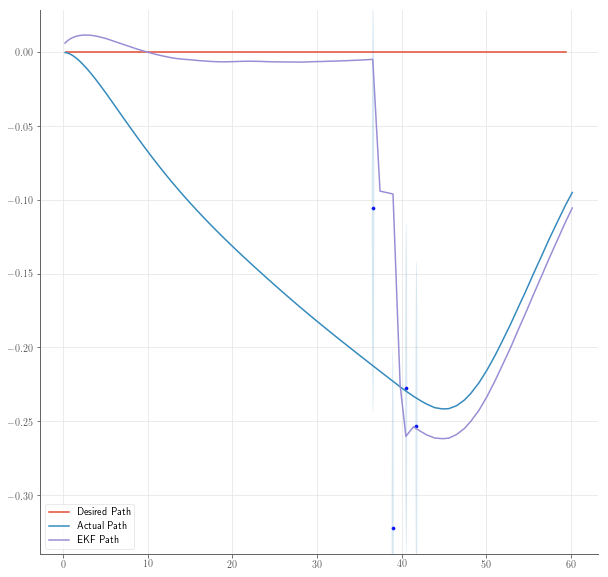

In [169]:
#*** THIS is good ***
print(bag)
skip_last = 50
ts, pts, actual_pts, ekf_pts, camera_updates = extract_path_points(bag)
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
ax.plot(pts[:-skip_last, 0], pts[:-skip_last, 1])
ax.plot(actual_pts[:-skip_last, 0], actual_pts[:-skip_last, 1])
ax.plot(ekf_pts[:-skip_last, 0], ekf_pts[:-skip_last, 1])
for (pos, cov), index in camera_updates:
    plt.scatter(pos[0], pos[1], color="blue", s=10)
    major, minor, angle = covariance_to_ellipse(cov)
#     print("Major, minor, angle:")
#     print(major, minor, angle)
    e = Ellipse(pos[:2], major*2*3, minor*2*3, np.rad2deg(angle)) # RECALL we encoded 3 stddevs!
    e.set_alpha(0.2)
    ax.add_artist(e)
    print("Camera position: {0}".format(pos))
    print("Real position: {0}".format(actual_pts[index]))
    print("Distance: {0}".format(np.linalg.norm(pos - actual_pts[index])))
    print("Major, minor lengths: {0}, {1}".format(major, minor))
plt.legend(("Desired Path", "Actual Path", "EKF Path"))
plt.show()


Number of camera updates: 2
[  1.54899477e-03   1.45061032e-05   1.45061032e-05   1.58750560e-03]
Pos, Major, minor, angle: [  3.83962090e+01  -1.43559179e-01   6.21724894e-15], 0.239426181896, 0.235773443984, 71.5036961547
[  1.54899477e-03   1.45061032e-05   1.45061032e-05   1.58750560e-03]
Pos, Major, minor, angle: [  3.90270599e+01  -3.08004980e-02   6.21724894e-15], 0.239426181896, 0.235773443984, 71.5036961547


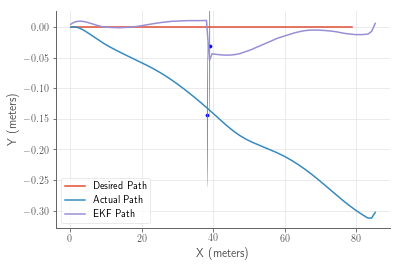

In [135]:
ts, pts, actual_pts, ekf_pts, camera_updates = extract_path_points(bag)
fig = plt.figure()
ax = fig.add_subplot(111)
print("Number of camera updates: {0}".format(len(camera_updates)))
ax.plot(pts[:-25, 0], pts[:-25, 1])
ax.plot(actual_pts[:-25, 0], actual_pts[:-25, 1])
ax.plot(ekf_pts[:-25, 0], ekf_pts[:-25, 1])
# plt.scatter([40], [-6]) # one camera location...
for (pos, cov), index in camera_updates:
    plt.scatter(pos[0], pos[1], color="blue", s=10)
    major, minor, angle = covariance_to_ellipse(cov)
    print(cov)
    angle = np.rad2deg(angle)
    print("Pos, Major, minor, angle: {3}, {0}, {1}, {2}".format(major*3*2, minor*3*2, angle, pos))
    e = Ellipse(pos[:2], major*3*2, minor*3*2, angle=angle)
    ax.add_artist(e)
plt.legend(("Desired Path", "Actual Path", "EKF Path"))
# plt.xlim(25,45)
# plt.ylim(-10,10)
plt.xlabel("X (meters)")
plt.ylabel("Y (meters)")

if save:
    plt.savefig('figs/impl/calibration_circuit_plain.pdf',bbox_inches='tight')
    plt.savefig('figs/impl/calibration_circuit_plain.pgf',bbox_inches='tight')
else:
    plt.show()
    


In [128]:
def extract_velocity_profiles(bag, straight_speed=20.0, radius_speed_mult=0.5):
    time_axis = []
    target_speeds = []
    actual_speeds = []
    ekf_speeds = []
    curvature_speeds = []
    for msg in bag:
        time_axis.append(msg.timestamp.to_sec())
        msg = msg.message
        target_speeds.append(msg.path_update.velocity_controller_target)
        actual_speeds.append(np.linalg.norm(vec_to_numpy(msg.true_odom.twist.twist.linear)))
        ekf_speeds.append(np.linalg.norm(vec_to_numpy(msg.ekf_odom.twist.twist.linear)))
        curvature = np.abs(msg.path_update.path_curvature)
        if curvature == 0.0:
            curvature_speeds.append(straight_speed)
        else:
            curvature_speeds.append(min(straight_speed, radius_speed_mult/curvature))
    return time_axis, target_speeds, actual_speeds, ekf_speeds, curvature_speeds

In [147]:
times, target, actual, ekf, curvature_speeds = extract_velocity_profiles(bag)

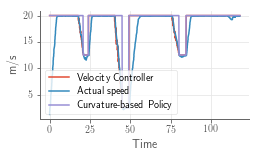

Average speed: 17.0914310208


In [148]:
plt.figure(figsize=(3.75,2))
t = np.array(times) - times[0]
_ = plt.plot(3*t[:-35], np.vstack([target[:-35], actual[:-35], curvature_speeds[:-35]]).T)
plt.legend(("Velocity Controller","Actual speed", "Curvature-based Policy"), loc="lower left")
plt.xlabel("Time")
plt.ylabel("m/s")
if save:
    plt.savefig('figs/impl/velocity_controller.pdf',bbox_inches='tight')
    plt.savefig('figs/impl/velocity_controller.pgf',bbox_inches='tight')
else:
    plt.show()
    
print("Average speed: {0}".format(np.mean(actual)))

In [149]:
def extract_crosstrack_error(bag):
    time_axis = []
    true_errors = []
    believed_errors = []
    curvature = []
    for msg in bag:
        time_axis.append(msg.timestamp.to_sec())
        msg = msg.message
        target_point = vec_to_numpy(msg.path_update.target_point)
        believed_pos = point_to_numpy(msg.ekf_odom.pose.pose.position)
        actual_pos = point_to_numpy(msg.true_odom.pose.pose.position)
        
        # since the exactly distance appears to be very unreliable (timing mismatch during data recording => record path target point from a different timestep as current point)
        # compute crosstrack distance here         
        normal = vec_to_numpy(msg.path_update.path_normal)
        diff_believed = believed_pos - target_point
        diff_actual = actual_pos - target_point
        # project onto normal
        true_errors.append(np.dot(normal, diff_actual))
        believed_errors.append(np.dot(normal, diff_believed))
        
        curvature.append(np.abs(msg.path_update.path_curvature))

        
    return np.array(time_axis), np.array(true_errors), np.array(believed_errors), np.array(curvature)

In [150]:
times, true_errors, believed_errors, curvatures = extract_crosstrack_error(bag)
radii = np.array([None if c == 0.0 else 0.1/c for c in curvatures])

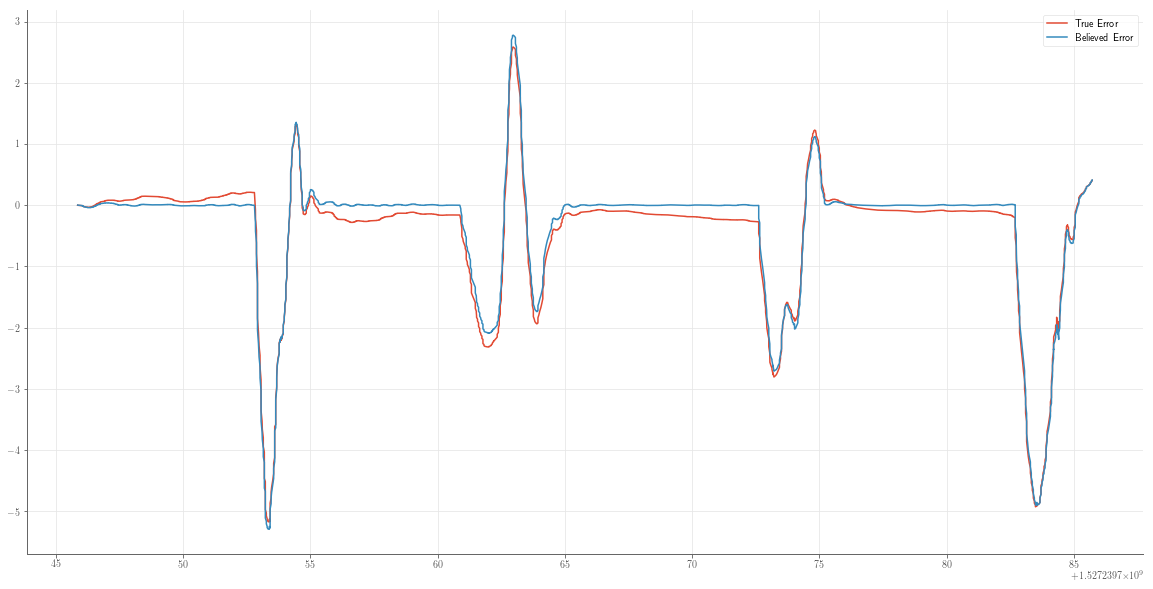

In [151]:
plt.figure(figsize=(20,10))
_ = plt.plot(times, np.vstack([true_errors, believed_errors]).T)
plt.legend(("True Error", "Believed Error"))
plt.show()

In [19]:
def extract_orientations(bag):
    time_axis = []
    true_headings = []
    believed_headings = []
    tangent_headings = []
    for msg in bag:
        time_axis.append(msg.timestamp.to_sec())
        msg = msg.message
        target_tangent = vec_to_numpy(msg.path_update.target_heading)
        # convert tangent to heading
        tangent_headings.append(np.rad2deg(np.arctan2(target_tangent[1], target_tangent[0])))
        if tangent_headings[-1] < -10:
            tangent_headings[-1] += 360
            
        # true heading
#         true_quat = quat_to_numpy(msg.true_odom.pose.pose.orientation)
#         true_rpy = np.rad2deg(quat_to_rpy(true_quat))
#         if true_rpy[2] < -10:
#             true_rpy[2] += 360
#         true_heading.append(true_rpy[2])
        vel = vec_to_numpy(msg.true_odom.twist.twist.linear)
        true_heading = np.rad2deg(np.arctan2(vel[1], vel[0]))
        if true_heading < -10:
            true_heading += 360
        true_headings.append(true_heading)
        
        #ekf heading
#         ekf_quat = quat_to_numpy(msg.ekf_odom.pose.pose.orientation)
#         ekf_rpy = np.rad2deg(quat_to_rpy(ekf_quat))
#         if ekf_rpy[2] < -10:
#             ekf_rpy[2] += 360
#         believed_headings.append(ekf_rpy[2])

        ekf_vel = vec_to_numpy(msg.ekf_odom.twist.twist.linear)
        ekf_heading = np.rad2deg(np.arctan2(ekf_vel[1], ekf_vel[0]))
        if ekf_heading < -10:
            ekf_heading += 360
        believed_headings.append(ekf_heading)
        
    return np.array(time_axis), np.array(true_headings), np.array(believed_headings), np.array(tangent_headings)

In [20]:
times, actual_headings, ekf_headings, curve_headings = extract_orientations(bag)

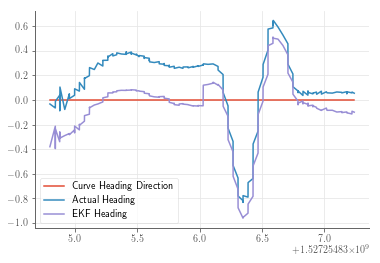

In [21]:
plt.plot(times, np.array([curve_headings, actual_headings, ekf_headings]).T)
plt.legend(("Curve Heading Direction", "Actual Heading", "EKF Heading"))
plt.show()

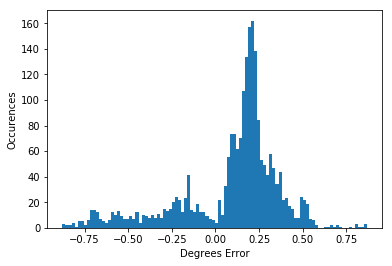

In [505]:
_ = plt.hist(ekf_headings - actual_headings, bins=100)
_ = plt.xlabel("Degrees Error")
_ = plt.ylabel("Occurences")

In [506]:
def process_bagfiles_for_final_errors(bags):
    # this is rather inefficient but not doing high volume right now
    positional_errors = []
    heading_errors = []
    
    for bagfile in bags:
        bag = rosbag.Bag(bagfile)
        ts, pts, actual_pts, ekf_pts, camera_updates = extract_path_points(bag)
        times, actual_headings, ekf_headings, curve_headings = extract_orientations(bag)
        
        # mostly want to check the distnace between the last positions and headings
        last_ekf_heading, last_actual_heading = ekf_headings[-1], actual_headings[-1]
        heading_errors.append(last_actual_heading - last_ekf_heading)
        
        last_actual_pt, last_ekf_pt = actual_pts[-1], ekf_pts[-1]
        positional_errors.append(np.linalg.norm(last_actual_pt - last_ekf_pt))
    return np.array(positional_errors), np.array(heading_errors)

In [507]:
flattened_all_bagfiles = [x for y in all_bag_files for x in y]
pos_errors, heading_errors = process_bagfiles_for_final_errors(flattened_all_bagfiles)

In [509]:
print(pos_errors,heading_errors)
print(np.mean(pos_errors), np.max(pos_errors))
print(np.mean(np.abs(heading_errors)), np.max(np.abs(heading_errors)))

(array([ 1.96890516,  0.5628624 ,  4.36672097,  2.72129894,  5.85119405,
        1.27629704,  0.32562549,  1.72797377,  1.46569681,  0.34732348]), array([ 0.17546798, -1.01433258, -0.22506999,  0.20367695, -0.07319636,
       -0.11097297,  0.06734313,  0.62188557, -0.05795875,  0.02038177]))
(2.0613898119306162, 5.8511940475902247)
(0.2570286052280541, 1.0143325836148498)


In [29]:
def pdf(mean, stddev, value):
    """ returns prob density at a given value """
    value_centered = value - mean
    var = float(stddev)**2
    denom = (2*np.pi*var)**0.5
    num = np.exp(-(value_centered)**2/(2*var))
    return num/denom


def pdf4(mean, stddev, value):
    # use a dx of 1/10000 of a stddev
    dx = stddev * 0.00001
    val = -1 * np.abs(value - mean)
    return st.norm.cdf(val, scale=stddev) - st.norm.cdf(val-dx, scale=stddev)

def pdf2(mean, stddev, value, dx=0.00000001):
    return st.norm.cdf(value-mean, scale=stddev) - st.norm.cdf(value-mean-dx, scale=stddev)


def pdf3(mean, stddev, value, dx=1e-8):
    val = value - mean
    z_score = np.abs(val)/stddev
    # loop up prob in a standard normal
    p1 = st.norm.cdf(-z_score)
    p2 = st.norm.cdf(-z_score + dx)
    return p2 - p1

def motion_model(ekf_start, ekf_end, ekf_start_heading, 
                 ekf_end_heading, actual_start, actual_end, 
                 actual_start_heading, actual_end_heading, 
                 alpha=np.array([0.0001, 0.0001, 0.0001, 0.0001]), scaling=1.0, verbose=False):
    """ Implements psoterior distribution from freiburg slides"""

    
    if verbose:
        print("\nActual points: {0}, {1}".format(actual_start, actual_end))
        print("Actual start heading: {0}, end heading: {1}".format(actual_start_heading, actual_end_heading))
        print("EKf points: {0}, {1}".format(ekf_start, ekf_end))
        print("EKF start heading: {0}, EKF end heading: {1}".format(ekf_start_heading, ekf_end_heading))
    
    if ekf_start_heading < 0:
        ekf_start_heading += 2*np.pi
    if ekf_end_heading < 0:
        ekf_end_heading += 2*np.pi
    if actual_start_heading < 0:
        actual_start_heading += 2*np.pi
    if actual_end_heading < 0:
        actual_end_heading += 2*np.pi
    
    # compute ground truth deltas
    diff_actual = actual_end - actual_start
    d_trans = np.linalg.norm(diff_actual)
    angle1 = np.arctan2(diff_actual[1], diff_actual[0])
    
    if verbose:
        print("Actual movement angle: {0}".format(angle1))
    if angle1 < 0:
        angle1 += 2*np.pi
    # just shift away from 2pi/0 boundaries when close
    if angle1 > 5 or angle1 < 1.2 or actual_start_heading > 5 or actual_start_heading < 1.2 or actual_end_heading > 5 or actual_end_heading < 1.2:
        angle1 = (angle1 + np.pi) % (2*np.pi) # this is safe since we only use d_rot1 and d_rot2 in abs!!
        actual_start_heading = (actual_start_heading + np.pi) % (2*np.pi)
        actual_end_heading = (actual_end_heading + np.pi) % (2*np.pi)
    d_rot1 = angle1 - actual_start_heading
    d_rot2 = actual_end_heading - angle1
    
    # compute believed deltas
    diff_ekf = ekf_end - ekf_start
    dhat_trans = np.linalg.norm(diff_ekf)
    angle2 = np.arctan2(diff_ekf[1], diff_ekf[0])
    
    if verbose:
        print("EKF movement angle: {0}".format(angle2))

        
    if angle2 < 0:
        angle2 += 2*np.pi

    # just shift away from 2pi/0 boundaries when close
    if angle2 > 5 or angle2 < 1.2 or ekf_start_heading > 5 or ekf_start_heading < 1.2 or ekf_end_heading > 5 or ekf_end_heading < 1.2:
        angle2 = (angle2 + np.pi) % (2*np.pi)
        ekf_start_heading = (ekf_start_heading + np.pi) % (2*np.pi)
        ekf_end_heading = (ekf_end_heading + np.pi) % (2*np.pi)

        
    dhat_rot1 = angle2 - ekf_start_heading
    dhat_rot2 = ekf_end_heading - angle2
    
    # compute probabilities of these occuring
    stddev1 = alpha[0]*np.abs(dhat_rot1) + alpha[1]*dhat_trans
    stddev2 = alpha[2]*dhat_trans + alpha[3]*(np.abs(dhat_rot1) + np.abs(dhat_rot2))
    stddev3 = alpha[0]*np.abs(dhat_rot1) + alpha[1]*dhat_trans
    
    p1 = pdf3(0, stddev1, d_rot1 - dhat_rot1)
    p2 = pdf3(0, stddev2, d_trans - dhat_trans)
    p3 = pdf3(0, stddev3, d_rot2 - dhat_rot2)
    
    value = scaling * p1 * p2 * p3
    
    if verbose:
        print("d_rot1: {0}, d_rot2: {1}, d_trans: {2}".format(d_rot1, d_rot2, d_trans))
        print("dhat_rot1: {0}, dhat_rot2: {1}, dhat_trans: {2}".format(dhat_rot1, dhat_rot2, dhat_trans))
        print("Diff rot1: {0}, diff trans: {1}, diff rot2: {2}".format(d_rot1 - dhat_rot1, d_trans-dhat_trans, d_rot2-dhat_rot2))
        print("stddev1: {0}, stddev2: {1}, stddev3: {2}".format(stddev1, stddev2, stddev3))

        print("P1: {0}, p2: {1}, P3: {2}, value: {3}".format(p1, p2, p3, value))
    
#     if (value > 10000 or value == 0.0) and verbose:
#         pass
    
    return value


def norm_2d_pdf(mean, cov, point):
    cov = cov.reshape((2,2))*2
    inv = np.linalg.inv(cov)
    det = np.linalg.det(cov)
    coeff = np.sqrt(4*np.pi*np.pi*det)
    centered = (point - mean)[:2]
    power = -0.5 * np.matmul(np.matmul(centered.T, inv), centered)
    return coeff * np.exp(power)


def apply_time_correction(camera_update, ekf_vel, ekf_time):
    # apply time-offset correction
    camera_update_time = camera_update.header.stamp.to_sec()
    camera_position = point_to_numpy(camera_update.position)
    dt = ekf_time - camera_update_time # move camera update forward by dt
    dx = ekf_vel * dt
    position = camera_position + dx
    # alternatively could also move EKF about, irrelevant!
    return position
            
    

        
def sensor_model(camera_network, camera_id, camera_position, ekf_pos):
    # General idea:
    # Use camera network, camera ID => camera instance
    # Then check p(measurement | state)
    # use the camera placement to obtain an error bound at that position
    # => use normal distribution to check p(get actual measurement)
    
    placement = camera_network.get_placement_by_id(camera_id)
  
    # get error bounds
    _, (major, minor, angle) = camera_network.get_location_and_error(placement, ekf_pos, ellipse=True)
    major = major/3.0
    minor = minor/3.0
    major_sq, minor_sq, cos_sq, sin_sq = major**2, minor**2, np.cos(angle)**2, np.sin(angle)**2
    varx = major_sq * cos_sq + minor_sq*sin_sq
    vary = major_sq*sin_sq + minor_sq*cos_sq
    covxy = (major_sq - minor_sq)*cos_sq * sin_sq
    cov = np.array([[varx, covxy], [covxy, vary]])
    
    return norm_2d_pdf(ekf_pos, cov, camera_position)
    
    
def get_normalizer(camera_network, camera_estimate, camera_id, ekf_pos, ekf_cov, n_samples=1000):
    placement = camera_network.get_placement_by_id(camera_id)
    # Need to compute: sum( p(zt | xt) * p(xt | u1:t, z1:t-1))
    # basically going to do via a mini monte-carlo
    # where samples are drawn from the distribution of x_t as given by the EKF!
    total = 0
    
    # pretty sure this would be VERY close if just used covariance of the ekf_pos
    # then sample around it, and generate probabilities with that one covariance
    # rather than sample, get covariance, get probability, repeat
    placement = camera_network.get_placement_by_id(camera_id)
    
#     # error bounds
#         pos = np.array([ekf_pos[0], ekf_pos[1], 0.0])
#     _, (major, minor, angle) = camera_network.get_location_and_error(placement, pos, ellipse=True)
#     major = major/3.0
#     minor = minor/3.0
#     major_sq, minor_sq, cos_sq, sin_sq = major**2, minor**2, np.cos(angle)**2, np.sin(angle)**2
#     varx = major_sq * cos_sq + minor_sq*sin_sq
#     vary = major_sq*sin_sq + minor_sq*cos_sq
#     covxy = (major_sq - minor_sq)*cos_sq * sin_sq
#     sample_covariance = np.array([[varx, covxy], [covxy, vary]])
    
    for _ in range(n_samples):
        # sample 2D normal according to N(ekf_pos, ekf_cov)
        sample_position = np.random.multivariate_normal(ekf_pos, ekf_cov)
        
        # get its covariance for position estimation
#         # error bounds
        pos = np.array([sample_position[0], sample_position[1], 0.0])
        _, (major, minor, angle) = camera_network.get_location_and_error(placement, pos, ellipse=True)
        major = major/3.0
        minor = minor/3.0
        major_sq, minor_sq, cos_sq, sin_sq = major**2, minor**2, np.cos(angle)**2, np.sin(angle)**2
        varx = major_sq * cos_sq + minor_sq*sin_sq
        vary = major_sq*sin_sq + minor_sq*cos_sq
        covxy = (major_sq - minor_sq)*cos_sq * sin_sq
        sample_covariance = np.array([[varx, covxy], [covxy, vary]])
        
        total += norm_2d_pdf(sample_position, sample_covariance, camera_estimate)
    return total
    
    
def calculate_probability(bag, camera_network, max_steps, verbose=False):
    prior_prob = 1.0
    motion_model_prob = prior_prob
    prob_movements = []
    n_skipped = 0
    timesteps = 0
    for i, msg in enumerate(bag):
        if i >= max_steps:
            break
        timesteps += 1
        msg = msg.message
        true_odom = msg.true_odom
        ekf_odom = msg.ekf_odom
        true_pos = point_to_numpy(true_odom.pose.pose.position)

        ekf_pos = point_to_numpy(ekf_odom.pose.pose.position)
        true_rpy = quat_to_rpy(quat_to_numpy(true_odom.pose.pose.orientation))
        true_heading = true_rpy[2]
        ekf_rpy = quat_to_rpy(quat_to_numpy(ekf_odom.pose.pose.orientation))
        ekf_heading = ekf_rpy[2]
        ekf_vel = point_to_numpy(ekf_odom.twist.twist.linear)
        ekf_time = ekf_odom.header.stamp.to_sec()
        ekf_positional_cov = np.array(ekf_odom.pose.covariance).reshape(6,6)[:2, :2]

        last_ekf_pos = np.array(list(msg.last_ekf_state[:2]) + [0.0])
        last_ekf_heading = msg.last_ekf_state[2]
        last_true_pos = point_to_numpy(msg.last_true_pos)
        last_true_heading = msg.last_true_heading
        
        camera_update = msg.camera_update
        if msg.has_camera_update:
            
            corrected_camera_position = apply_time_correction(camera_update, ekf_vel, ekf_time)
            prob_sensor_measurements = sensor_model(camera_network, camera_update.source_camera_id, corrected_camera_position, ekf_pos)

            eta = get_normalizer(camera_network, corrected_camera_position[:2], camera_update.source_camera_id, ekf_pos[:2], ekf_positional_cov, n_samples=1000)

#             print("Camera probability/eta: {0}".format(prob_sensor_measurements/eta))
            if prob_sensor_measurements == 0.0:
                prob_sensor_measurements = 4.62560605847e-270 # some small number!
        else:
            prob_sensor_measurements = 1 # ie. there were none
            eta = 1
        
        if np.array_equal(last_true_pos, true_pos):
            continue
        
        
        prob_movement = motion_model(last_ekf_pos, ekf_pos, 
                                     last_ekf_heading, ekf_heading, 
                                     last_true_pos, true_pos,
                                     last_true_heading, true_heading, scaling=1, verbose=verbose)
        
        
        # need to get eta, the normalizing constant...
        # = sum(x_t, p(z_t | x_t) * p(x_t | u_1:t, z_1:t-1))
        
        value = prob_movement * prob_sensor_measurements / eta
        if value == 0.0:
            print "*********** 0.0!! ********"
            n_skipped += 1
            continue
        motion_model_prob *= value
        
#         prob_movements.append(prob_movement)
#         if motion_model_prob > 1000:
#             print(motion_model_prob)

    return motion_model_prob, timesteps, n_skipped


def calculate_mean_entropy_of_runs(def_file, bag_files, verbose=False, skip_last=10):
    # need def file to set up camera network
    with open(def_file) as f:
        config = json.load(f)
    
    #  ----- create the camera network -----
    

    # get error magnitudes
    camera_config = config['cameras']
    errors = camera_config['errors']
    alg_error = errors['alg_error']
    pos_error_stddev = errors['pos_error_stddev']
    orient_error_stddev = errors['orient_error_stddev']
    

    camera_network = CameraNetwork.CameraNetwork(positional_error_stddev=pos_error_stddev,
                                    orient_error_stddev=orient_error_stddev, 
                                    alg_error=alg_error)


    # get road definition
    road_width = config['road']['width']
    side_offset = config['road']['side_offset']
    segments = config['road']['path']['segments']
    looping = config['road']['path']['loop']
    
    path = Path.Path(loop=looping)
    for segment in segments:
        curvature = segment["curvature"]
        path.add_segment(curvature=segment["curvature"], length=segment["length"])

    # don't actually need this, mostly need width and side offset...
    # may be used further later though!
    road = RoadModel.Road(path, width=road_width, side_offset=side_offset)

    for segment in path.segments:
        # create the world objects which define boundaries
        if segment.curvature == 0.0:
            continue # skip, only curved boundaries for now
        midpoint_dist = segment.start_time + segment.get_length()/2.0
        midpoint = segment.point_at(midpoint_dist)
        normal = segment.normal_at(midpoint_dist)

        road_radius = np.abs(1.0/segment.curvature) 
        cylinder_radius = road_radius - road.halfwidth - road.side_offset 
        cylinder_center = midpoint + normal * road_radius
        cylinder_direction = np.array([0.0, 0.0, 1.0])
        
        camera_network.add_world_object(Tracer.Cylinder(cylinder_center, cylinder_direction, cylinder_radius))

    cameras = camera_config['placements']    
    for i, conf in enumerate(cameras):

        placement = CameraNetwork.CameraPlacement(i, np.array(conf['position']), 
                     conf['pitch_degrees'], 
                     conf['yaw_degrees'], 
                     model=conf['model'], 
                     resolution=conf['resolution'], 
                     fov=conf['fov'],
                     positional_error_stddev=pos_error_stddev,
                     orientation_error_stddev=orient_error_stddev
                 )

        # position in list will be its ID
        # TODO brittle
        camera_network.add_placement(placement)

    
    # need to find out the sample with the smallest number of time steps
    # don't want to multiply more time steps in one than another
    
    total_entropy, n = 0, len(bag_files)
    
    # first go through each one and count the number of timesteps to find the minimum
    smallest_timesteps = 999999
    for i, filename in enumerate(bag_files):
        bag = rosbag.Bag(filename)
        count = bag.get_message_count()
        if count < smallest_timesteps:
            smallest_timesteps = count
    
    smallest_timesteps -= skip_last
    
    for i, filename in enumerate(bag_files):
        bag = rosbag.Bag(filename)
        
        probability, timesteps, n_skipped = calculate_probability(bag, camera_network, verbose=verbose, max_steps=smallest_timesteps)
        entropy = -1*probability * np.log(probability)
        if not np.isnan(entropy) and not np.isinf(entropy):
            total_entropy += entropy
            
        print("Proability of run {0}: {1}, Entropy: {2} from {3} timesteps skipped {4}".format(i, probability, entropy, timesteps, n_skipped))
#         total_entropy += probability
    
    return total_entropy/n
    
        

In [30]:
for i, def_file in enumerate(specific_experiments):
    bagfiles = all_bag_files[i]
    mean_entropy = calculate_mean_entropy_of_runs(os.path.join('defs', def_file), bagfiles, verbose=False, skip_last=10)
    print("======> Mean entropy of {0}, {1} simulations: {2}".format(def_file, len(all_bag_files[i]), mean_entropy))


ROSBagUnindexedException: Unindexed bag

In [488]:
for i, def_file in enumerate(specific_experiments):
    bagfiles = all_bag_files[i]
    mean_entropy = calculate_mean_entropy_of_runs(os.path.join('defs', def_file), bagfiles, verbose=False)
    print("Mean entropy of {0}, {1} simulations: {2}".format(def_file, len(all_bag_files[i]), mean_entropy))


Camera probability/eta: 0.00127958484334
Camera probability/eta: 0.00148405464707
Camera probability/eta: 0.00104288038198
Camera probability/eta: 0.00132804413025
Camera probability/eta: 0.00147808387864
Camera probability/eta: 2.46578615316e-11
Camera probability/eta: 1.70402377692e-14
Camera probability/eta: 8.69969842532e-05
Proability of run 0: 4.73577845538e-312, Entropy: -3.39484942955e-309 from 148 timesteps skipped 0
Camera probability/eta: 0.000873639202074
Camera probability/eta: 7.15308266514e-05
Camera probability/eta: 6.45496549663e-05
Camera probability/eta: 6.75013357723e-10
Camera probability/eta: 9.19650821174e-06
Camera probability/eta: 0.000975973263212
Camera probability/eta: 2.59751178202e-13
Camera probability/eta: 2.59054332469e-14
Proability of run 1: 0.0, Entropy: nan from 148 timesteps skipped 0
Mean entropy of straight_road_80m_centercam_pos3.json, 2 simulations: -1.69742471477e-309


/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:361: RuntimeWarning: divide by zero encountered in log
/usr/local/lib/python2.7/dist-packages/ipykernel_launcher.py:361: RuntimeWarning: invalid value encountered in double_scalars


In [182]:
print(bag)
for msg in bag:
    print msg.message

path:        gen/straight_road_80m_centercam_pos1/runner_0/run_0/sim_data.bag
version:     2.0
duration:    2.5s
start:       May 22 2018 15:54:47.25 (1527000887.25)
end:         May 22 2018 15:54:49.76 (1527000889.76)
size:        322.7 KB
messages:    178
compression: none [1/1 chunks]
types:       custom_messages/SimulationDataMsg [d22491d4d453904df2c5ce7e314ea29c]
topics:      /simulation_data   178 msgs @ 2.4 kHz : custom_messages/SimulationDataMsg
header: 
  seq: 1
  stamp: 
    secs: 63
    nsecs: 272000000
  frame_id: "map"
true_odom: 
  header: 
    seq: 544
    stamp: 
      secs: 63
      nsecs: 134000000
    frame_id: "map"
  child_frame_id: "base_link"
  pose: 
    pose: 
      position: 
        x: 0.134029206171
        y: 2.08513167834e-05
        z: 0.00535419694454
      orientation: 
        x: -9.07905296512e-07
        y: 0.000382897095066
        z: 0.000109294894642
        w: 0.999999920722
    covariance: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 

header: 
  seq: 108
  stamp: 
    secs: 68
    nsecs: 372000000
  frame_id: "map"
true_odom: 
  header: 
    seq: 1052
    stamp: 
      secs: 68
      nsecs: 214000000
    frame_id: "map"
  child_frame_id: "base_link"
  pose: 
    pose: 
      position: 
        x: 54.4161500593
        y: 0.046987398403
        z: 0.00539908582411
      orientation: 
        x: -1.90098154221e-06
        y: 0.00038482062661
        z: -0.00164112403653
        w: 0.99999857931
    covariance: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
  twist: 
    twist: 
      linear: 
        x: 19.6602998782
        y: -0.0631481222705
        z: -0.000506644029834
      angular: 
        x: -9.24853213054e-05
        y: -0.00421418046065
        z: -0.0942649895705
    covariance: [0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0

In [254]:
flattened_all_bagfiles = []
for files in all_bag_files:
    flattened_all_bagfiles += files
# bagfile = rosbag.Bag(all_bag_files[0][0])
# for b in flattened_all_bagfiles:
#     bag = rosbag.Bag(b)
val, n_skipped, ps = calculate_conditional_entropy(bag, camera_network=None, skip_first=0, verbose=False)
print("Prob of path: {0}".format(val))

Prob of path: 1.0755546108e+52


In [179]:

def log_motion_model(ekf_start, ekf_end, ekf_start_heading, 
                 ekf_end_heading, actual_start, actual_end, 
                 actual_start_heading, actual_end_heading, 
                 alpha=np.array([0.0001, 0.0001, 0.0001, 0.0001]), scaling=1.0, verbose=False):
    """ Implements psoterior distribution from freiburg slides"""

    
    if verbose:
        print("\nActual points: {0}, {1}".format(actual_start, actual_end))
        print("Actual start heading: {0}, end heading: {1}".format(actual_start_heading, actual_end_heading))
        print("EKf points: {0}, {1}".format(ekf_start, ekf_end))
        print("EKF start heading: {0}, EKF end heading: {1}".format(ekf_start_heading, ekf_end_heading))
    
    if ekf_start_heading < 0:
        ekf_start_heading += 2*np.pi
    if ekf_end_heading < 0:
        ekf_end_heading += 2*np.pi
    if actual_start_heading < 0:
        actual_start_heading += 2*np.pi
    if actual_end_heading < 0:
        actual_end_heading += 2*np.pi
    
    # compute ground truth deltas
    diff_actual = actual_end - actual_start
    d_trans = np.linalg.norm(diff_actual)
    angle1 = np.arctan2(diff_actual[1], diff_actual[0])
    
    if verbose:
        print("Actual movement angle: {0}".format(angle1))
    if angle1 < 0:
        angle1 += 2*np.pi
    # just shift away from 2pi/0 boundaries when close
    if angle1 > 5 or angle1 < 1.2 or actual_start_heading > 5 or actual_start_heading < 1.2 or actual_end_heading > 5 or actual_end_heading < 1.2:
        angle1 = (angle1 + np.pi) % (2*np.pi) # this is safe since we only use d_rot1 and d_rot2 in abs!!
        actual_start_heading = (actual_start_heading + np.pi) % (2*np.pi)
        actual_end_heading = (actual_end_heading + np.pi) % (2*np.pi)
    d_rot1 = angle1 - actual_start_heading
    d_rot2 = actual_end_heading - angle1
    
    # compute believed deltas
    diff_ekf = ekf_end - ekf_start
    dhat_trans = np.linalg.norm(diff_ekf)
    angle2 = np.arctan2(diff_ekf[1], diff_ekf[0])
    
    if verbose:
        print("EKF movement angle: {0}".format(angle2))

        
    if angle2 < 0:
        angle2 += 2*np.pi

    # just shift away from 2pi/0 boundaries when close
    if angle2 > 5 or angle2 < 1.2 or ekf_start_heading > 5 or ekf_start_heading < 1.2 or ekf_end_heading > 5 or ekf_end_heading < 1.2:
        angle2 = (angle2 + np.pi) % (2*np.pi)
        ekf_start_heading = (ekf_start_heading + np.pi) % (2*np.pi)
        ekf_end_heading = (ekf_end_heading + np.pi) % (2*np.pi)

        
    dhat_rot1 = angle2 - ekf_start_heading
    dhat_rot2 = ekf_end_heading - angle2
    
    # compute probabilities of these occuring
    stddev1 = alpha[0]*np.abs(dhat_rot1) + alpha[1]*dhat_trans
    stddev2 = alpha[2]*dhat_trans + alpha[3]*(np.abs(dhat_rot1) + np.abs(dhat_rot2))
    stddev3 = alpha[0]*np.abs(dhat_rot1) + alpha[1]*dhat_trans
    
    p1 = np.log(pdf2(0, stddev1, d_rot1 - dhat_rot1, dx=1e-5))
    p2 = np.log(pdf2(0, stddev2, d_trans - dhat_trans, dx=1e-5))
    p3 = np.log(pdf2(0, stddev3, d_rot2 - dhat_rot2, dx=1e-5))
    
    value = p1 + p2 + p3
    
    if verbose:
        print("d_rot1: {0}, d_rot2: {1}, d_trans: {2}".format(d_rot1, d_rot2, d_trans))
        print("dhat_rot1: {0}, dhat_rot2: {1}, dhat_trans: {2}".format(dhat_rot1, dhat_rot2, dhat_trans))
        print("Diff rot1: {0}, diff trans: {1}, diff rot2: {2}".format(d_rot1 - dhat_rot1, d_trans-dhat_trans, d_rot2-dhat_rot2))
        print("stddev1: {0}, stddev2: {1}, stddev3: {2}".format(stddev1, stddev2, stddev3))

        print("LOG P1: {0}, p2: {1}, P3: {2}, value: {3}".format(p1, p2, p3, value))
    
#     if (value > 10000 or value == 0.0) and verbose:
#         pass
    
    return value


def norm_2d_pdf(mean, cov, point):
    cov = cov.reshape((2,2))*2
    inv = np.linalg.inv(cov)
    det = np.linalg.det(cov)
    coeff = np.sqrt(4*np.pi*np.pi*det)
    centered = (point - mean)[:2]
    power = -0.5 * np.matmul(np.matmul(centered.T, inv), centered)
    return coeff * np.exp(power)


def apply_time_correction(camera_update, ekf_vel, ekf_time):
    # apply time-offset correction
    camera_update_time = camera_update.header.stamp.to_sec()
    camera_position = point_to_numpy(camera_update.position)
    dt = ekf_time - camera_update_time # move camera update forward by dt
    dx = ekf_vel * dt
    position = camera_position + dx
    # alternatively could also move EKF about, irrelevant!
    return position
            
    

        
def sensor_model(camera_network, camera_id, camera_position, ekf_pos):
    # General idea:
    # Use camera network, camera ID => camera instance
    # Then check p(measurement | state)
    # use the camera placement to obtain an error bound at that position
    # => use normal distribution to check p(get actual measurement)
    
    placement = camera_network.get_placement_by_id(camera_id)
    
    # get error bounds
    _, (major, minor, angle) = camera_network.get_location_and_error(placement, ekf_pos, ellipse=True)
    major = major/3.0
    minor = minor/3.0
    major_sq, minor_sq, cos_sq, sin_sq = major**2, minor**2, np.cos(angle)**2, np.sin(angle)**2
    varx = major_sq * cos_sq + minor_sq*sin_sq
    vary = major_sq*sin_sq + minor_sq*cos_sq
    covxy = (major_sq - minor_sq)*cos_sq * sin_sq
    cov = np.array([[varx, covxy], [covxy, vary]])
    
    return norm_2d_pdf(ekf_pos, cov, camera_position)
    
    
def get_normalizer(camera_network, camera_estimate, camera_id, ekf_pos, ekf_cov, n_samples=1000):
    placement = camera_network.get_placement_by_id(camera_id)
    # Need to compute: sum( p(zt | xt) * p(xt | u1:t, z1:t-1))
    # basically going to do via a mini monte-carlo
    # where samples are drawn from the distribution of x_t as given by the EKF!
    total = 0
    
    # pretty sure this would be VERY close if just used covariance of the ekf_pos
    # then sample around it, and generate probabilities with that one covariance
    # rather than sample, get covariance, get probability, repeat
    placement = camera_network.get_placement_by_id(camera_id)
    
#     # error bounds
#         pos = np.array([ekf_pos[0], ekf_pos[1], 0.0])
#     _, (major, minor, angle) = camera_network.get_location_and_error(placement, pos, ellipse=True)
#     major = major/3.0
#     minor = minor/3.0
#     major_sq, minor_sq, cos_sq, sin_sq = major**2, minor**2, np.cos(angle)**2, np.sin(angle)**2
#     varx = major_sq * cos_sq + minor_sq*sin_sq
#     vary = major_sq*sin_sq + minor_sq*cos_sq
#     covxy = (major_sq - minor_sq)*cos_sq * sin_sq
#     sample_covariance = np.array([[varx, covxy], [covxy, vary]])
    
    for _ in range(n_samples):
        # sample 2D normal according to N(ekf_pos, ekf_cov)
        sample_position = np.random.multivariate_normal(ekf_pos, ekf_cov)
        
        # get its covariance for position estimation
#         # error bounds
        pos = np.array([sample_position[0], sample_position[1], 0.0])
        _, (major, minor, angle) = camera_network.get_location_and_error(placement, pos, ellipse=True)
        major = major/3.0
        minor = minor/3.0
        major_sq, minor_sq, cos_sq, sin_sq = major**2, minor**2, np.cos(angle)**2, np.sin(angle)**2
        varx = major_sq * cos_sq + minor_sq*sin_sq
        vary = major_sq*sin_sq + minor_sq*cos_sq
        covxy = (major_sq - minor_sq)*cos_sq * sin_sq
        sample_covariance = np.array([[varx, covxy], [covxy, vary]])
        
        total += norm_2d_pdf(sample_position, sample_covariance, camera_estimate)
    return total
    
    
def calculate_log_probability(bag, camera_network, max_steps, verbose=False):
    prior_prob = 1.0
    log_motion_model_prob = np.log(prior_prob)
    prob_movements = []
    n_skipped = 0
    timesteps = 0
    for i, msg in enumerate(bag):
        if i >= max_steps:
            break
        timesteps += 1
        msg = msg.message
        true_odom = msg.true_odom
        ekf_odom = msg.ekf_odom
        true_pos = point_to_numpy(true_odom.pose.pose.position)

        ekf_pos = point_to_numpy(ekf_odom.pose.pose.position)
        true_rpy = quat_to_rpy(quat_to_numpy(true_odom.pose.pose.orientation))
        true_heading = true_rpy[2]
        ekf_rpy = quat_to_rpy(quat_to_numpy(ekf_odom.pose.pose.orientation))
        ekf_heading = ekf_rpy[2]
        ekf_vel = point_to_numpy(ekf_odom.twist.twist.linear)
        ekf_time = ekf_odom.header.stamp.to_sec()
        ekf_positional_cov = np.array(ekf_odom.pose.covariance).reshape(6,6)[:2, :2]

        last_ekf_pos = np.array(list(msg.last_ekf_state[:2]) + [0.0])
        last_ekf_heading = msg.last_ekf_state[2]
        last_true_pos = point_to_numpy(msg.last_true_pos)
        last_true_heading = msg.last_true_heading
        
        camera_update = msg.camera_update
        if msg.has_camera_update:
            
            # no longer need to correct since sampling normal => add to true pos
#             corrected_camera_position = apply_time_correction(camera_update, ekf_vel, ekf_time)
            corrected_camera_position = point_to_numpy(camera_update.position)
            prob_sensor_measurements = sensor_model(camera_network, camera_update.source_camera_id, corrected_camera_position, ekf_pos)

            eta = get_normalizer(camera_network, corrected_camera_position[:2], camera_update.source_camera_id, ekf_pos[:2], ekf_positional_cov, n_samples=1000)

        else:
            prob_sensor_measurements = 1 # ie. there were none
            eta = 1
        
        if np.array_equal(last_true_pos, true_pos):
            continue
        
        
        log_prob_movement = log_motion_model(last_ekf_pos, ekf_pos, 
                                     last_ekf_heading, ekf_heading, 
                                     last_true_pos, true_pos,
                                     last_true_heading, true_heading, scaling=1, verbose=verbose)
        
        
        # need to get eta, the normalizing constant...
        # = sum(x_t, p(z_t | x_t) * p(x_t | u_1:t, z_1:t-1))
        
        value = log_prob_movement + bf.log(prob_sensor_measurements/eta)
#         value = log_prob_movement
    
        if value == 0.0:
            print "*********** 0.0!! ********"
            n_skipped += 1
            continue
        log_motion_model_prob += value
        if verbose:
            print("Log prob xt -> xt+1: {0}".format(log_prob_movement))
            print("prob sensor measurement: {0}".format(prob_sensor_measurements))
            print("eta: {0}".format(eta))
            print("Current log prob: {0}".format(log_motion_model_prob))
        
#         prob_movements.append(prob_movement)
#         if motion_model_prob > 1000:
#             print(motion_model_prob)

    return log_motion_model_prob, timesteps, n_skipped


def calculate_mean_entropy_of_runs2(def_file, bag_files, verbose=False, max_steps=120):
    # need def file to set up camera network
    with open(def_file) as f:
        config = json.load(f)
    
    #  ----- create the camera network -----
    

    # get error magnitudes
    camera_config = config['cameras']
    errors = camera_config['errors']
    alg_error = errors['alg_error']
    pos_error_stddev = errors['pos_error_stddev']
    orient_error_stddev = errors['orient_error_stddev']
    

    camera_network = CameraNetwork.CameraNetwork(positional_error_stddev=pos_error_stddev,
                                    orient_error_stddev=orient_error_stddev, 
                                    alg_error=alg_error)


    # get road definition
    road_width = config['road']['width']
    side_offset = config['road']['side_offset']
    segments = config['road']['path']['segments']
    looping = config['road']['path']['loop']
    
    path = Path.Path(loop=looping)
    for segment in segments:
        curvature = segment["curvature"]
        path.add_segment(curvature=segment["curvature"], length=segment["length"])

    # don't actually need this, mostly need width and side offset...
    # may be used further later though!
    road = RoadModel.Road(path, width=road_width, side_offset=side_offset)

    for segment in path.segments:
        # create the world objects which define boundaries
        if segment.curvature == 0.0:
            continue # skip, only curved boundaries for now
        midpoint_dist = segment.start_time + segment.get_length()/2.0
        midpoint = segment.point_at(midpoint_dist)
        normal = segment.normal_at(midpoint_dist)

        road_radius = np.abs(1.0/segment.curvature) 
        cylinder_radius = road_radius - road.halfwidth - road.side_offset 
        cylinder_center = midpoint + normal * road_radius
        cylinder_direction = np.array([0.0, 0.0, 1.0])
        
        camera_network.add_world_object(Tracer.Cylinder(cylinder_center, cylinder_direction, cylinder_radius))

    cameras = camera_config['placements']    
    for i, conf in enumerate(cameras):

        placement = CameraNetwork.CameraPlacement(i, np.array(conf['position']), 
                     conf['pitch_degrees'], 
                     conf['yaw_degrees'], 
                     model=conf['model'], 
                     resolution=conf['resolution'], 
                     fov=conf['fov'],
                     positional_error_stddev=pos_error_stddev,
                     orientation_error_stddev=orient_error_stddev
                 )

        # position in list will be its ID
        # TODO brittle
        camera_network.add_placement(placement)

    
    # need to find out the sample with the smallest number of time steps
    # don't want to multiply more time steps in one than another
    
    total_entropy, n = 0, len(bag_files)
    
    # first go through each one and count the number of timesteps to find the minimum
    smallest_timesteps = 999999
    for i, filename in enumerate(bag_files):
        bag = rosbag.Bag(filename)
        count = bag.get_message_count()
        if count < smallest_timesteps:
            smallest_timesteps = count
    
    smallest_timesteps = min(smallest_timesteps, max_steps)
    
    for i, filename in enumerate(bag_files):
        bag = rosbag.Bag(filename)
        
        log_probability, timesteps, n_skipped = calculate_log_probability(bag, camera_network, verbose=verbose, max_steps=smallest_timesteps)
        entropy = -1*bf.exp(log_probability) * (log_probability) # use bigfloat
#         if not np.isnan(entropy) and not np.isinf(entropy):
        total_entropy += entropy
            
        print("Log Proability of run {0}: {1}, Entropy: {2} from {3} timesteps skipped {4}".format(i, log_probability, entropy, timesteps, n_skipped))
#         total_entropy += probability
    
    return total_entropy/n
    
        

In [180]:
for i, def_file in enumerate(specific_experiments):
    bagfiles = all_bag_files[i]
    mean_entropy = calculate_mean_entropy_of_runs2(os.path.join('defs', def_file), bagfiles, verbose=False, max_steps=120)
    print("Mean entropy of {0}, {1} simulations: {2}\n\n".format(def_file, len(bagfiles), mean_entropy))


Log Proability of run 0: -1118.5174313813905, Entropy: 1.9173190845267929e-483 from 120 timesteps skipped 0
Log Proability of run 1: -1065.3880662572294, Entropy: 2.1644600120254213e-460 from 120 timesteps skipped 0
Log Proability of run 2: -1049.6845189881483, Entropy: 1.4088490268859870e-453 from 120 timesteps skipped 0
Log Proability of run 3: -1106.5136368801141, Entropy: 3.0987755661123403e-478 from 120 timesteps skipped 0
Log Proability of run 4: -1125.9480534795498, Entropy: 1.1441733251900879e-486 from 120 timesteps skipped 0
Log Proability of run 5: -1106.0808180234615, Entropy: 4.7751943728438483e-478 from 120 timesteps skipped 0
Log Proability of run 6: -1156.7096251194348, Entropy: 5.1359051628699240e-500 from 120 timesteps skipped 0
Log Proability of run 7: -1094.7718239438518, Entropy: 3.8544421289372991e-473 from 120 timesteps skipped 0
Log Proability of run 8: -1053.6542046327420, Entropy: 2.6698766576924684e-455 from 120 timesteps skipped 0
Log Proability of run 9: -10